### Main Imports

In [1]:
# Libaries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from glob import glob

# Python Libraries
import json
import math
import os
import shutil

### Tensorflow Imports

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.python import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import save_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, layers


Num GPUs Available:  1


### Constants and Directories
I reordered directory structure from Kaggle dataset

In [3]:
STD_IMAGE_SIZE = (512, 512)

In [4]:
INPUT_DIR = os.path.join(".", "pulmonary-chest-abnormalities")
CHINASET_INPUT_DIR = os.path.join(INPUT_DIR, "ChinaSet_AllFiles")
DATA_INPUT_DIR = os.path.join(INPUT_DIR, "data")

MANUAL_MASK_DIR = os.path.join(INPUT_DIR, "ManualMask")
MANUAL_LEFT_DIR = os.path.join(MANUAL_MASK_DIR, "leftMask")
MANUAL_RIGHT_DIR = os.path.join(MANUAL_MASK_DIR, "rightMask")

CXR_PNG_DIR = os.path.join(INPUT_DIR, "CXR_png")
CLINICAL_READINGS_DIR = os.path.join(INPUT_DIR, "ClinicalReadings")

CHINASET_CLINICAL_READINGS_DIR = os.path.join(CHINASET_INPUT_DIR, "ClinicalReadings")
CHINASET_CXR_PNG_DIR = os.path.join(CHINASET_INPUT_DIR, "CXR_png")

IMAGES_DIR = os.path.join(DATA_INPUT_DIR, "images")
MASKS_DIR = os.path.join(DATA_INPUT_DIR, "masks")
TRAIN_DIR = os.path.join(DATA_INPUT_DIR, "train")

IMAGES_VAL_DIR = os.path.join(DATA_INPUT_DIR, "images_val")
IMAGES_AUG_DIR = os.path.join(DATA_INPUT_DIR, "images_aug")
MASKS_VAL_DIR = os.path.join(DATA_INPUT_DIR, "masks_val")

IMAGES_TRAIN_DIR = os.path.join(TRAIN_DIR, "images_train")
MASKS_TRAIN_DIR = os.path.join(TRAIN_DIR, "masks_train")

### Image Preprocessing

In [5]:
left_manual_mask = glob(os.path.join(MANUAL_LEFT_DIR, "*.png"))
right_manual_mask = glob(os.path.join(MANUAL_RIGHT_DIR, "*.png"))


for left_image in left_manual_mask:
    
    # Get file names
    base_file = os.path.basename(left_image)
    main_image = os.path.join(CXR_PNG_DIR, base_file)
    right_image = os.path.join(MANUAL_RIGHT_DIR, base_file)
    
    main = cv2.imread(main_image)
    left = cv2.imread(left_image, cv2.IMREAD_GRAYSCALE)
    right = cv2.imread(right_image, cv2.IMREAD_GRAYSCALE)
    
    # Risize the images
    main = cv2.resize(main, STD_IMAGE_SIZE)
    left = cv2.resize(left, STD_IMAGE_SIZE)
    right = cv2.resize(right, STD_IMAGE_SIZE)
    
    # Combine the two masks into one using numpy (This is neat and easy!)
    mask = np.maximum(left, right)
       
    cv2.imwrite(os.path.join(IMAGES_DIR, base_file), main)
    cv2.imwrite(os.path.join(MASKS_DIR, base_file), mask)

In [6]:
print(len(left_manual_mask))

138


### Test/Validation Split with Preprocessed Images

In [7]:
# Move 70% of images in the first to the other 
images = glob(os.path.join(IMAGES_DIR, "*.png"))
masks = glob(os.path.join(MASKS_DIR, "*.png"))

percent_subarray = math.floor(0.75 * len(images))

# Move 75/25 of the data into the respective directories
for image in images[:percent_subarray]:
    shutil.copy(image, IMAGES_TRAIN_DIR)
for image in images[percent_subarray:]:
    shutil.copy(image, IMAGES_VAL_DIR)
for image in masks[:percent_subarray]:
    shutil.copy(image, MASKS_TRAIN_DIR)
for image in masks[percent_subarray:]:
    shutil.copy(image, MASKS_VAL_DIR)

### Model Generation
#### Data Generator

In [8]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
#         save_to_dir = save_to_dir,
#         save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
#         save_to_dir = save_to_dir,
#         save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)
        
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

#### Dice Coefficient and Loss Functions

In [9]:
# Dice coefficient for segmentation tasks
def dice_coef(y_true, y_pred):
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Loss function from the dice coefficient, we want to maximize overlap
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#### Helper Lambda Functions for Model Definition

In [10]:

# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (3, 3),
    'padding': 'same'}

# --- Define lambda functions
conv = lambda x, filters, strides : layers.Conv2D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.LeakyReLU()(x)

# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(2, 2))))

# --- Define single transpose
tran = lambda x, filters, strides : layers.Conv2DTranspose(filters=filters, strides=strides, **kwargs)(x)

# --- Define transpose block
tran2 = lambda filters, x : relu(norm(tran(x, filters, strides=(2, 2))))

# --- Concatenate
concat = lambda a, b : layers.Concatenate()([a, b])

In [11]:
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # --- Define contracting layers
    l1 = conv1(16, inputs)
    l2 = conv1(32, conv2(32, l1))
    l3 = conv1(64, conv2(64, l2))
    l4 = conv1(128, conv2(128, l3))
    l5 = conv1(256, conv2(256, l4))
    
    # --- Define transposing layers
    l6 = tran2(128, l5)
    l7 = tran2(64, conv1(128, concat(l4, l6)))
    l8 = tran2(32, conv1(64, concat(l3, l7)))
    l9 = tran2(16, conv1(32, concat(l2, l8)))
    l10 = conv1(16, l9)
    
    l11 = Conv2D(1, (1,1), activation="sigmoid")(l10)
    
    return Model(inputs=[inputs], outputs=[l11])

In [12]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(8,
                            TRAIN_DIR,
                            'images_train',
                            'masks_train', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(IMAGES_AUG_DIR))

In [13]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5),
              loss=dice_coef_loss,
              metrics=[dice_coef, 'binary_accuracy'])
# model.summary()

In [176]:
model_checkpoint = ModelCheckpoint('unet_lung_seg-2.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit_generator(train_gen,
                             steps_per_epoch=128,
                             epochs=20, 
                             callbacks=[model_checkpoint])

  ...
    to  
  ['...']
Train for 128 steps
Epoch 1/20
127/128 [============================>.] - ETA: 0s - loss: 0.2443 - dice_coef: 0.7557 - binary_accuracy: 0.9711
Epoch 00001: loss improved from inf to 0.24375, saving model to unet_lung_seg-2.hdf5
128/128 [==============================] - 39s 308ms/step - loss: 0.2438 - dice_coef: 0.7562 - binary_accuracy: 0.9711
Epoch 2/20
127/128 [============================>.] - ETA: 0s - loss: 0.2406 - dice_coef: 0.7594 - binary_accuracy: 0.9721
Epoch 00002: loss improved from 0.24375 to 0.24026, saving model to unet_lung_seg-2.hdf5
128/128 [==============================] - 39s 308ms/step - loss: 0.2404 - dice_coef: 0.7596 - binary_accuracy: 0.9722
Epoch 3/20
127/128 [============================>.] - ETA: 0s - loss: 0.2370 - dice_coef: 0.7630 - binary_accuracy: 0.9732
Epoch 00003: loss improved from 0.24026 to 0.23676, saving model to unet_lung_seg-2.hdf5
128/128 [==============================] - 39s 307ms/step - loss: 0.2367 - dice_coef:

In [17]:
xs, ys = next(train_gen)
model.load_weights("unet_lung_seg-2.hdf5")
pred_ys = model.predict(xs)
pred_ys[0].shape

(512, 512, 1)

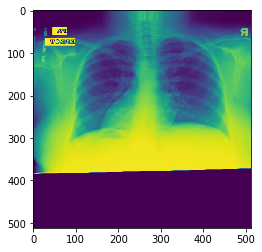

In [20]:
imshow(xs[0].reshape(512, 512))

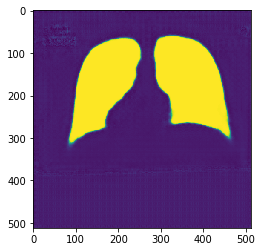

In [18]:
imshow(pred_ys[0].reshape(512, 512))

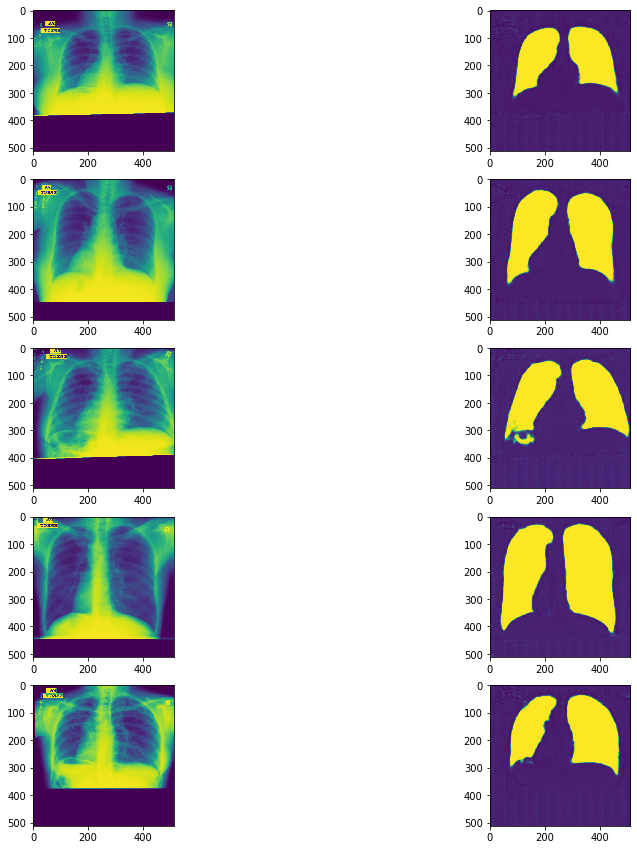

In [19]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

for i in range(5):
    axs[i][0].imshow(xs[i].reshape(512, 512))
for i in range(5):
    axs[i][1].imshow(pred_ys[i].reshape(512, 512))    
